In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/DATASET.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATASET/TRAIN/R/R_5000.jpg  
  inflating: DATASET/TRAIN/R/R_5001.jpg  
  inflating: DATASET/TRAIN/R/R_5002.jpg  
  inflating: DATASET/TRAIN/R/R_5003.jpg  
  inflating: DATASET/TRAIN/R/R_5004.jpg  
  inflating: DATASET/TRAIN/R/R_5005.jpg  
  inflating: DATASET/TRAIN/R/R_5006.jpg  
  inflating: DATASET/TRAIN/R/R_5007.jpg  
  inflating: DATASET/TRAIN/R/R_5008.jpg  
  inflating: DATASET/TRAIN/R/R_5009.jpg  
  inflating: DATASET/TRAIN/R/R_5010.jpg  
  inflating: DATASET/TRAIN/R/R_5011.jpg  
  inflating: DATASET/TRAIN/R/R_5012.jpg  
  inflating: DATASET/TRAIN/R/R_5013.jpg  
  inflating: DATASET/TRAIN/R/R_5014.jpg  
  inflating: DATASET/TRAIN/R/R_5015.jpg  
  inflating: DATASET/TRAIN/R/R_5016.jpg  
  inflating: DATASET/TRAIN/R/R_5017.jpg  
  inflating: DATASET/TRAIN/R/R_5018.jpg  
  inflating: DATASET/TRAIN/R/R_5019.jpg  
  inflating: DATASET/TRAIN/R/R_5020.jpg  
  inflating: DATASET/TRAIN/R/R_5021.jpg  
  inflating: DATASET/TRAI

In [4]:
my_data_dir = "/content/DATASET"

In [5]:
os.listdir(my_data_dir)

['TEST', 'TRAIN']

In [6]:
test_path = my_data_dir+'/TEST'
train_path = my_data_dir+'/TRAIN'

In [7]:
os.listdir(train_path)

['N', 'O', 'R']

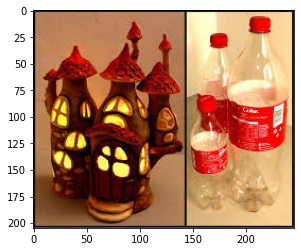

In [8]:
N = train_path+'/N'+'/'+os.listdir(train_path+'/N')[2]
N_img= imread(N)
plt.imshow(N_img)

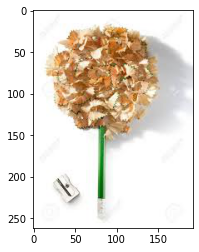

In [9]:
O = train_path+'/O'+'/'+os.listdir(train_path+'/O')[0]
O_img= imread(O)
plt.imshow(O_img)

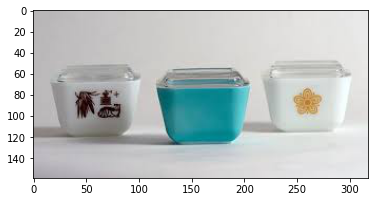

In [10]:
R = train_path+'/R'+'/'+os.listdir(train_path+'/R')[98]
R_img= imread(R)
plt.imshow(R_img)

In [11]:
print("For training data:")
print("N: "+str(len(os.listdir(train_path+'/N'))))
print("O: "+str(len(os.listdir(train_path+'/O'))))
print("R: "+str(len(os.listdir(train_path+'/R'))))

For training data:
N: 2847
O: 12565
R: 7152


In [12]:
print("For testing data:")
print("N: "+str(len(os.listdir(test_path+'/N'))))
print("O: "+str(len(os.listdir(test_path+'/O'))))
print("R: "+str(len(os.listdir(test_path+'/R'))))

For testing data:
N: 397
O: 1401
R: 1112


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False  # randomly flip images
)

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224,224),
        batch_size=128,
        class_mode='categorical',
        shuffle=True
)

Found 22564 images belonging to 3 classes.


In [17]:
validation_generator = val_datagen.flow_from_directory(
        test_path,
        target_size=(224,224),
        batch_size=128,
        class_mode='categorical',
        shuffle=False
)

Found 2907 images belonging to 3 classes.


In [18]:
img_size = 224
batch_size = 128

In [19]:
train_generator.class_indices

{'N': 0, 'O': 1, 'R': 2}

In [20]:
class_names=['Non-Recyclable','Organic','Recyclable']

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [23]:
base_model = MobileNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [24]:
for layer in base_model.layers:
    layer.trainable=False

In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [26]:
model=Sequential()

model.add(base_model)
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation="softmax"))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

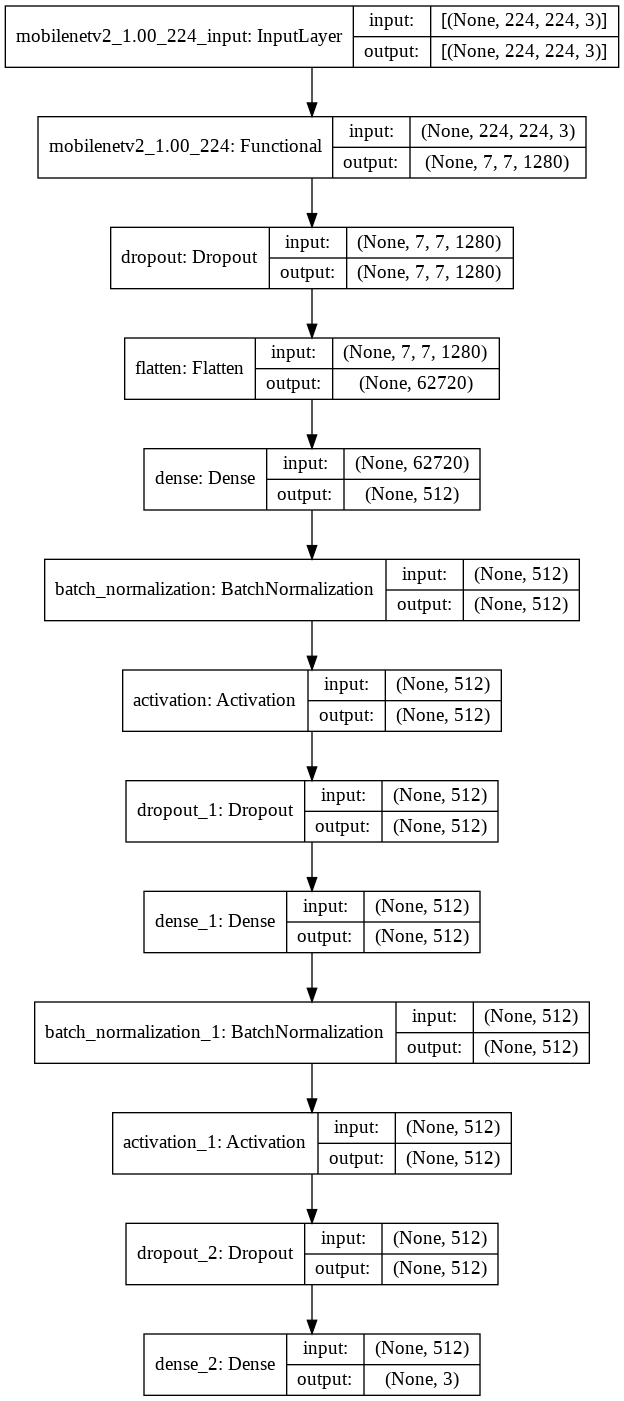

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='MobileNetmodel.png', show_shapes=True, show_layer_names=True)

In [29]:
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [31]:
checkpoint = ModelCheckpoint('MobileNet.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_weights_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_acc',
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callback_list = [earlystopping, checkpoint]

In [32]:
history=model.fit(train_generator,
                validation_data=validation_generator,
                epochs=10,
                callbacks=callback_list,
                verbose=1,  
)

Epoch 1/10
177/177 [==============================] - 292s 1s/step - loss: 0.3559 - accuracy: 0.8639 - val_loss: 0.5799 - val_accuracy: 0.7781

Epoch 00001: saving model to MobileNet.h5
Epoch 2/10
177/177 [==============================] - 261s 1s/step - loss: 0.2424 - accuracy: 0.9077 - val_loss: 0.6334 - val_accuracy: 0.7723

Epoch 00002: saving model to MobileNet.h5
Epoch 3/10
177/177 [==============================] - 261s 1s/step - loss: 0.1958 - accuracy: 0.9275 - val_loss: 0.6020 - val_accuracy: 0.7984

Epoch 00003: saving model to MobileNet.h5
Epoch 4/10
177/177 [==============================] - 265s 1s/step - loss: 0.1715 - accuracy: 0.9351 - val_loss: 0.5618 - val_accuracy: 0.8043

Epoch 00004: saving model to MobileNet.h5
Epoch 5/10
177/177 [==============================] - 265s 1s/step - loss: 0.1496 - accuracy: 0.9449 - val_loss: 0.6392 - val_accuracy: 0.7919

Epoch 00005: saving model to MobileNet.h5
Epoch 6/10
177/177 [==============================] - 260s 1s/step - l

In [33]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("MobileNetmodel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("MobileNetmodel.h5")  
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


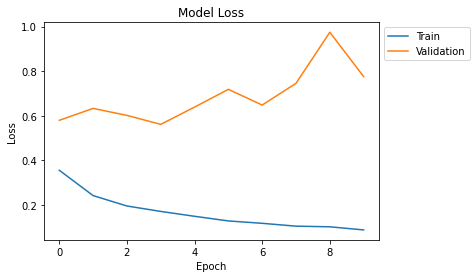

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

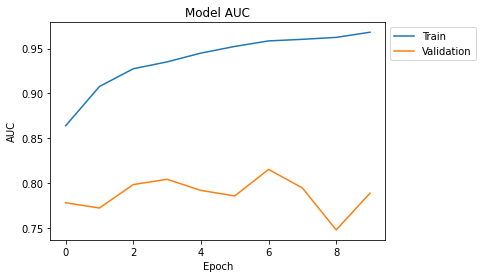

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [40]:
from tensorflow.keras.models import model_from_json
#with open('/content/drive/MyDrive/waste classification weights/Xceptionmodel.json','r') as f:
    #json = f.read()
#model = model_from_json(json)
#best m0del weight
model.load_weights("/content/drive/MyDrive/waste classification weights/MobileNetmodel.h5")

In [41]:
model.evaluate(validation_generator)

23/23 [==============================] - 6s 268ms/step - loss: 0.7756 - accuracy: 0.7888


[0.7756305932998657, 0.7887856960296631]

In [42]:
preds = model.predict(validation_generator)
pred = []
for i in preds:
    pred.append(np.argmax(i))

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [44]:
validation_generator.classes

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [45]:
print(confusion_matrix(validation_generator.classes, pred))

[[ 277   22   95]
 [  12 1374   15]
 [ 229  241  642]]


In [47]:
df=confusion_matrix(validation_generator.classes, pred)

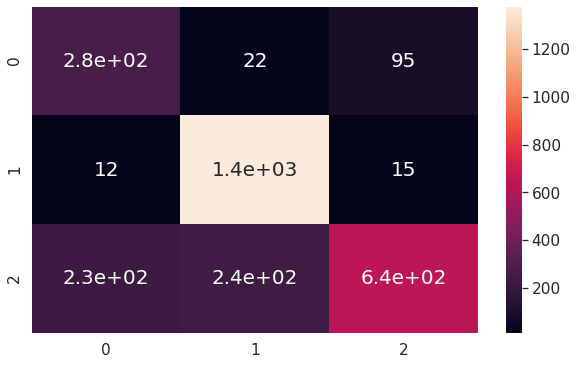

In [48]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [49]:
print(classification_report(validation_generator.classes, pred,target_names=class_names))

                precision    recall  f1-score   support

Non-Recyclable       0.53      0.70      0.61       394
       Organic       0.84      0.98      0.90      1401
    Recyclable       0.85      0.58      0.69      1112

      accuracy                           0.79      2907
     macro avg       0.74      0.75      0.73      2907
  weighted avg       0.80      0.79      0.78      2907



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Organic'

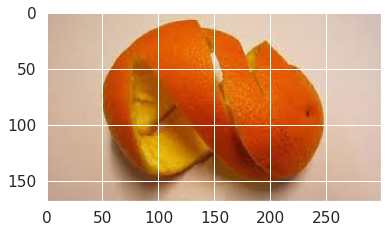

In [116]:
X_test_dir = test_path+'/O'+'/'+os.listdir(test_path+'/O')[10]
X_test_img= imread(X_test_dir)
plt.imshow(X_test_img)
img = cv2.resize(X_test_img,(224,224))
img = np.reshape(img,[1,224,224,3])
classes = model.predict_classes(img)
idx=classes.astype(np.int32).item()
class_names[idx]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Recyclable'

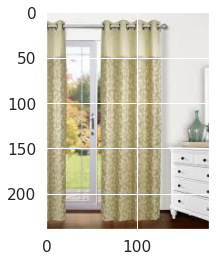

In [117]:
X_test_dir = test_path+'/R'+'/'+os.listdir(test_path+'/R')[10]
X_test_img= imread(X_test_dir)
plt.imshow(X_test_img)
img = cv2.resize(X_test_img,(224,224))
img = np.reshape(img,[1,224,224,3])
classes = model.predict_classes(img)
idx=classes.astype(np.int32).item()
class_names[idx]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Non-Recyclable'

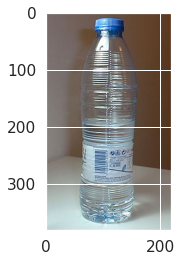

In [119]:
X_test_dir = test_path+'/N'+'/'+os.listdir(test_path+'/N')[160]
X_test_img= imread(X_test_dir)
plt.imshow(X_test_img)
img = cv2.resize(X_test_img,(224,224))
img = np.reshape(img,[1,224,224,3])
classes = model.predict_classes(img)
idx=classes.astype(np.int32).item()
class_names[idx]

In [91]:
validation_generator.class_indices

{'N': 0, 'O': 1, 'R': 2}

In [ ]:
encoder_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
encoder_model.summary()

In [51]:
encoder_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0   

In [52]:
output_train=encoder_model.predict(train_generator)
output_test=encoder_model.predict(validation_generator)

In [53]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_generator.labels)
test_labels = to_categorical(validation_generator.labels)
print("Train Labels", train_labels.shape)
print("Test Labels", test_labels.shape)

Train Labels (22564, 3)
Test Labels (2907, 3)


In [54]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 42)

In [55]:
rf_model.fit(output_train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [86]:
pickle.dump(rf_model, open("rf_model", 'wb'))

In [56]:
rf_preds = rf_model.predict(output_test)

In [57]:
print(confusion_matrix(validation_generator.classes,rf_preds.argmax(axis=1)))

[[  88  306    0]
 [ 122 1279    0]
 [  45 1067    0]]


In [58]:
df=confusion_matrix(validation_generator.classes,rf_preds.argmax(axis=1))

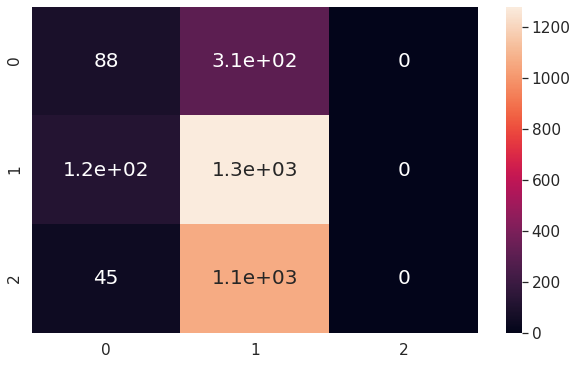

In [59]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [60]:
print(classification_report(test_labels.argmax(axis=1),rf_preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.35      0.22      0.27       394
           1       0.48      0.91      0.63      1401
           2       0.00      0.00      0.00      1112

    accuracy                           0.47      2907
   macro avg       0.28      0.38      0.30      2907
weighted avg       0.28      0.47      0.34      2907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
from xgboost import XGBClassifier

In [76]:
xgb_model = XGBClassifier(max_depth=10, objective='multi:softprob', n_estimators=128, random_state=24) 

In [77]:
xgb_model.fit(output_train, train_generator.classes)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=128, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
xgb_preds = xgb_model.predict(output_test)

In [85]:
import pickle
pickle.dump(xgb_model, open("xgb_model", 'wb'))

In [79]:
print(confusion_matrix(validation_generator.classes,xgb_preds))

[[   0  358   36]
 [   0 1348   53]
 [   0 1070   42]]


In [80]:
df=confusion_matrix(validation_generator.classes,xgb_preds)

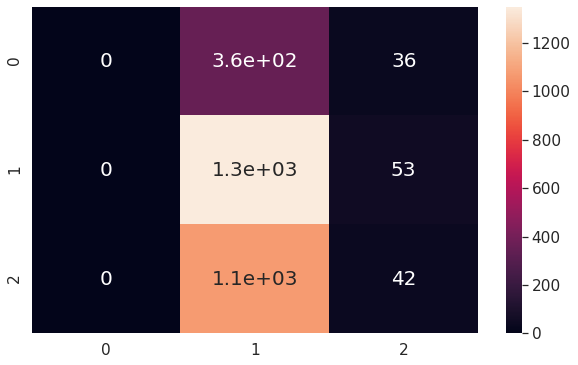

In [81]:
df_cm = pd.DataFrame(df, range(3), range(3))
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size

plt.show()

In [82]:
print(classification_report(test_labels.argmax(axis=1),xgb_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       394
           1       0.49      0.96      0.65      1401
           2       0.32      0.04      0.07      1112

    accuracy                           0.48      2907
   macro avg       0.27      0.33      0.24      2907
weighted avg       0.36      0.48      0.34      2907



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
